In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [15]:
import glob

datasets=[]
for f in glob.glob("models/*.csv"):
    fd=pd.read_csv(f,header=None,names=['Date','Price']).set_index('Date')
    datasets.append(Flight(flight=f,dpt_dt=fd.index[-1],data=fd['Price'])) 
    print(f)
            

models/Boston_to_Allentown.csv
models/Albany_to_Philadelphia.csv
models/Flint_to_Syracuse.csv
models/USA_to_Providance.csv
models/USA_to_Philadelphia.csv
models/Rochester_to_Syracuse.csv
models/Boston_to_Providance.csv


In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
#add time to departure at 0 index
ds=datasets
df = pd.DataFrame()
df['t'] = [x for x in ds[0].data]
dataframe = series_to_supervised(df, 7)

datatime_vect=np.vectorize(np.datetime64)
try:
    date1=datatime_vect(ds[0].data.index.values)
    date2=datatime_vect(ds[0].dpt_dt)
except:
    date1=ds[0].data.index.values
    date2=ds[0].dpt_dt
daysBDpt=((date2-date1)+1).astype('timedelta64[D]')[7:]
dataframe.insert(0, 'daysBDpt', pd.Series(daysBDpt.astype(int),index=dataframe.index))

array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

dataframe.head()

daysBDpt  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
7        313      366.0      363.0      367.0      371.0      374.0   
8        312      363.0      367.0      371.0      374.0      377.0   
9        311      367.0      371.0      374.0      377.0      379.0   
10       310      371.0      374.0      377.0      379.0      380.0   
11       309      374.0      377.0      379.0      380.0      382.0   

    var1(t-2)  var1(t-1)  var1(t)  
7       377.0      379.0    380.0  
8       379.0      380.0    382.0  
9       380.0      382.0    384.0  
10      382.0      384.0    385.0  
11      384.0      385.0    385.0

In [25]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=500, random_state=1)

model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [26]:
model.predict(X[0:2,0:])

array([ 380.284,  381.452])

In [27]:
from sklearn.feature_selection import RFE

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 4)
fit = rfe.fit(X, y)
fit.ranking_

array([1, 4, 3, 5, 2, 1, 1, 1])

In [28]:
dataframe.columns

Index(['daysBDpt', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)',
       'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)'],
      dtype='object')

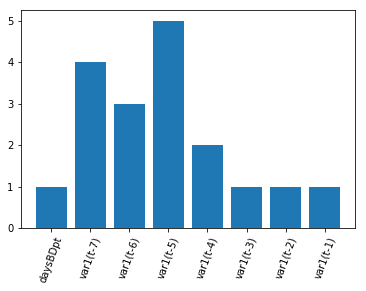

In [29]:
# plot feature rank
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.xticks(rotation=70)
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
import warnings
from sklearn.grid_search import RandomizedSearchCV

def getXY(dataset,lags=5):
    df = pd.DataFrame()
    df['t'] = [x for x in dataset.data]
    dataframe = series_to_supervised(df, lags)

    datatime_vect=np.vectorize(np.datetime64)
    try:
        date1=datatime_vect(dataset.data.index.values)
        date2=datatime_vect(dataset.dpt_dt)
    except:
        date1=dataset.data.index.values
        date2=dataset.dpt_dt
    daysBDpt=((date2-date1)+1).astype('timedelta64[D]')[lags:]
    dataframe.insert(0, 'daysBDpt', pd.Series(daysBDpt.astype(int),index=dataframe.index))

    array = dataframe.values
    # split into input and output
    X = array[:,0:-1]
    y = array[:,-1]

    return (X,y)

def selectModel(models,params,X_train, X_test, y_train, y_test,splits=3):
  warnings.filterwarnings("ignore")
  best_score, best_model = float("inf"), None  
  seed=123
  kfold = KFold(n_splits=splits, random_state=seed)

  score=[]
  for model,param in zip(models,params):         
    try:
        #gs=GridSearchCV(model,param,cv=kfold,refit=True,n_jobs=-1)
        gs=RandomizedSearchCV(model,param,cv=3,refit=True,n_jobs=-1)
        gs.fit(X_train,y_train)
        mse=mean_squared_error(y_test, gs.best_estimator_.predict(X_test))
        r2=r2_score(y_test, gs.best_estimator_.predict(X_test))
        print(str(model.__class__).split(".")[-1], gs.best_params_, mse,r2)
        if mse < best_score:
           best_score, best_model = mse, gs        
    except Exception as e:
        print(e)
  print("Score(mse): %s"%best_score)  

  return (best_model,X_train, X_test, y_train, y_test)


def testmodels(models,params,dataset,lags=5,splits=3):
  print(dataset.flight)  
  xy=getXY(dataset,lags)
  X_train, X_test, y_train, y_test = train_test_split(xy[0], xy[1], test_size=0.34, random_state=42)#, shuffle=False)      

  return selectModel(models,params,X_train, X_test, y_train, y_test,splits)+(dataset,)


/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

models=[#SVR(),
        RandomForestRegressor(n_jobs=-1,oob_score = True),make_pipeline(StandardScaler(),MLPRegressor(random_state=9))]
params=[
#         {"C": [1e-5,1e-3,0.01,1], 
#             "gamma": [1e-5, 0.001, 0.01, 0.1, 1, 10],
#             "kernel":['rbf','poly','linear'], 
#             "degree":[1,2,3]},
        {'n_estimators': [5,10,100,500,700,1000,1200],
            'max_features': ['sqrt', 'log2'],  
            'max_depth': [5,10,100,500,700,1000,1200]},
        {'mlpregressor__hidden_layer_sizes': [(1000,),(200,),(150,),(100,),(10,5),(5,5),(10,10),(15,15),(10,10,10)],                                 
            'mlpregressor__alpha': stats.uniform(1e-20,1),
            'mlpregressor__activation': ['relu','identity', 'logistic', 'tanh'], 
            'mlpregressor__solver' : ['lbfgs'] #'adam' for big data
        }]

best_model,X_train, X_test, y_train, y_test, ds=testmodels(models,params,datasets[0])


models/Boston_to_Allentown.csv
RandomForestRegressor'> {'n_estimators': 10, 'max_features': 'log2', 'max_depth': 1000} 28.765462963 0.975022254528
Pipeline'> {'mlpregressor__activation': 'logistic', 'mlpregressor__alpha': 0.72544575018467428, 'mlpregressor__hidden_layer_sizes': (200,), 'mlpregressor__solver': 'lbfgs'} 59.3009754115 0.948507532384
Score(mse): 28.765462963


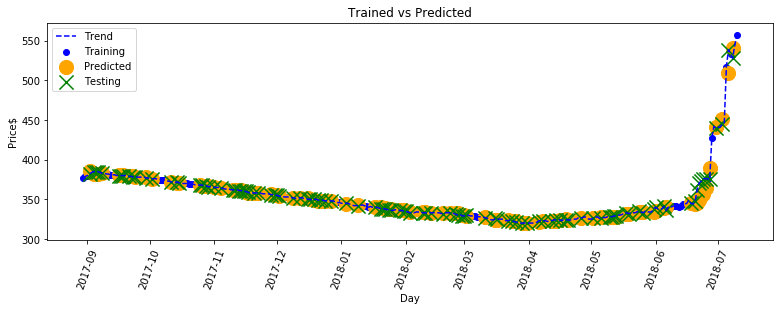

In [36]:
def plotResults(ds,model,X_train, X_test, y_train, y_test,test_only=False):    
    try:
        begin_time=np.datetime64(ds.dpt_dt)
    except:
        begin_time=ds.dpt_dt
    train_ind=begin_time-[np.timedelta64(int(x)) for x in X_train[:,0]]
    test_ind=begin_time-[np.timedelta64(int(x)) for x in X_test[:,0]]
    y_trainS=pd.Series(y_train,index=train_ind).sort_index()
    y_testS=pd.Series(y_test,index=test_ind).sort_index()

    y_pred=model.best_estimator_.predict(X_test)
    y_predS=pd.Series(y_pred,index=test_ind).sort_index()
    plt.figure(figsize=(13,4))    
    if not test_only:
        plt.plot(pd.concat([y_trainS,y_testS]).sort_index(),'b--',label='Trend')
        plt.scatter(y_trainS.index,y_trainS,color="blue",label="Training")            
        plt.scatter(y_predS.index,y_predS, marker="o",s=200, color= 'orange',label="Predicted")
        plt.scatter(y_testS.index,y_testS, marker="x",s=200,color = 'green',label="Testing")
    else:        
        plt.plot(y_predS.index.values,y_predS, marker="o",color= 'orange',label="Predicted")
        plt.plot(y_testS.index.values,y_testS,color = 'green',label="Testing")
    
    
    plt.title('Trained vs Predicted')
    plt.xlabel('Day')
    plt.ylabel('Price$')
    plt.legend()
    plt.xticks(rotation=70)        
    
    plt.show()
    
plotResults(datasets[0],best_model,X_train, X_test, y_train, y_test)